In [229]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [230]:
data = pd.read_csv('bank-data.csv') # data from https://www.fdic.gov
data.head()

,CERT,CHCLASS1,CITYST,COST,FAILDATE,FIN,ID,NAME,QBFASSET,QBFDEP,RESTYPE,RESTYPE1,SAVR
0,NaN,NM,"EAST PEORIA, IL",NaN,5/28/1934,0,1,FON DU LAC STATE BANK,374.0,238.0,FAILURE,PO,FDIC
1,NaN,NM,"GRANTWOOD, NJ",NaN,1/3/1935,0,10,CLIFFSIDE PARK TITLE GUARANTEE & TRUST CO.,2305.0,590.0,FAILURE,PO,FDIC
2,NaN,NM,"CUMMINGS, ND",NaN,12/21/1936,0,100,THE CUMMINGS STATE BANK,NaN,30.0,FAILURE,P&A,FDIC
3,13797.0,NM,"TAYLOR, NE",1653.0,5/31/1985,2466,1000,BANK OF TAYLOR,14542.0,13360.0,FAILURE,PA,FDIC
4,18388.0,NM,"FAIRFIELD, NE",1656.0,5/31/1985,6571,1001,FAIRFIELD STATE BANK,6795.0,6034.0,FAILURE,PO,FDIC


In [231]:
data.columns

Index(['CERT', 'CHCLASS1', 'CITYST', 'COST', 'FAILDATE', 'FIN', 'ID', 'NAME',
       'QBFASSET', 'QBFDEP', 'RESTYPE', 'RESTYPE1', 'SAVR'],
      dtype='object')

RESTYPE will be our outcome variable - a binary variable denoting FAILURE or ASSISTANCE.

In [232]:
data.info

<bound method DataFrame.info of          CERT CHCLASS1           CITYST     COST    FAILDATE   FIN    ID  \
0         NaN       NM  EAST PEORIA, IL      NaN   5/28/1934     0     1   
1         NaN       NM    GRANTWOOD, NJ      NaN    1/3/1935     0    10   
2         NaN       NM     CUMMINGS, ND      NaN  12/21/1936     0   100   
3     13797.0       NM       TAYLOR, NE   1653.0   5/31/1985  2466  1000   
4     18388.0       NM    FAIRFIELD, NE   1656.0   5/31/1985  6571  1001   
...       ...      ...              ...      ...         ...   ...   ...   
4104  30934.0       SL   TITUSVILLE, FL   7096.0    5/2/1985  1666   987   
4105  28448.0       SB  NEW ORLEANS, LA  51544.0   5/10/1985  1718   991   
4106  30054.0       SL       MARION, OH      0.0   5/22/1985  1667   994   
4107  29052.0       SL     FREEPORT, IL  13607.0   5/28/1985  1721   996   
4108   9477.0       NM     WOODBURN, OR  18791.0   5/31/1985  1923   998   

                                            NAME  QBFAS

In [233]:
#describing the data
print(data.describe())


               CERT          COST           FIN           ID      QBFASSET  \
count   3621.000000  3.472000e+03   4109.000000  4109.000000  3.955000e+03   
mean   24519.410660  8.469810e+04   4176.718180  2055.000000  1.366148e+06   
std    11651.915609  5.223738e+05   3331.469667  1186.310457  3.129309e+07   
min       40.000000 -1.138100e+04      0.000000     1.000000  1.400000e+01   
25%    18279.000000  3.161000e+03   1754.000000  1028.000000  1.796250e+04   
50%    26353.000000  1.131500e+04   2967.000000  2055.000000  5.555500e+04   
75%    30990.000000  4.290175e+04   7030.000000  3082.000000  1.969650e+05   
max    91189.000000  1.782003e+07  12894.000000  4109.000000  1.471631e+09   

             QBFDEP  
count  4.107000e+03  
mean   7.524135e+05  
std    1.621087e+07  
min    0.000000e+00  
25%    1.463250e+04  
50%    4.954400e+04  
75%    1.749410e+05  
max    9.546776e+08  


In [234]:
what_are_restypes = data['RESTYPE'].value_counts()
what_are_restypes

RESTYPE
FAILURE       3516
ASSISTANCE     593
Name: count, dtype: int64

# Data Cleaning

In [235]:
test = data.isna().sum()
test

CERT        488
CHCLASS1      0
CITYST        0
COST        637
FAILDATE      0
FIN           0
ID            0
NAME          0
QBFASSET    154
QBFDEP        2
RESTYPE       0
RESTYPE1      0
SAVR          0
dtype: int64

In [236]:
X = pd.DataFrame(data[['COST', 'QBFASSET', 'QBFDEP']].values)

y = data['RESTYPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Our X will consist of each bank's cost (COST), total assets (QBFASSET), and total deposits (QBFDEP). 

In [237]:
X_train.corr()

,0,1,2
0,1.000000,0.173733,0.187681
1,0.173733,1.000000,0.994227
2,0.187681,0.994227,1.000000


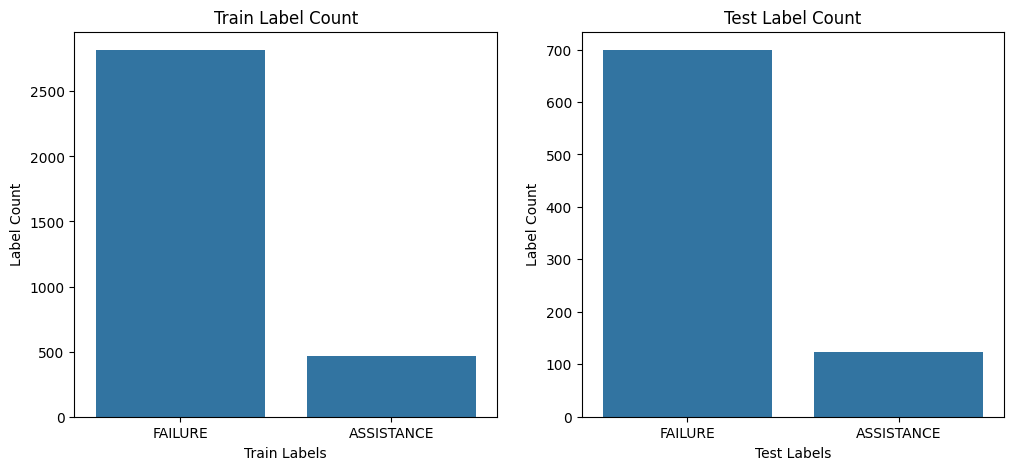

In [238]:
# Courtesy of Stackoverflow: https://stackoverflow.com/questions/70379709/visualization-data-train-and-data-test-from-train-test-split-with-seaborn

fig, ax = plt.subplots(1,2, figsize=(12,5))
for idx, group in enumerate([('Train', y_train), ('Test', y_test)]):
    datum = group[1].value_counts()
    sns.barplot(ax=ax[idx], x=datum.index, y=datum.values)
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

plt.show()

## Handling the imbalanced data -> Let's explore Microsoft's LightGBM!

According to Wikipedia, LightGBM is short for light gradient-boosting machine. It is a free and open-source distributed gradient-boosting framework for machine learning, originally developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks.

Okay, let's handle missing values:

In [239]:
data = data.replace([np.inf, -np.inf], np.nan).dropna()

for c in data.columns:
    data[c]=data[c].apply(str)
    le=preprocessing.LabelEncoder().fit(data[c])
    data[c] =le.transform(data[c])
    pd.to_numeric(data[c]).astype(float)

X = pd.DataFrame(data[['COST', 'QBFASSET', 'QBFDEP']].values)
y = data['RESTYPE']
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.2)




Next, let's explore logistic regression on our split data

In [240]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, multioutput= 'uniform_average') # Replace with the appropriate error calculation depending on the task
print("Mean Squared Error:", mse)

Accuracy: 0.8517985611510791
Mean Squared Error: 0.14820143884892087


To evaluate the performance of the model while the training process goes on let’s split the dataset in 75:25 ratio and then use it to create lgb dataset and then train the model.

Reference: https://www.geeksforgeeks.org/regression-using-lightgbm/

In [241]:
# Standardize Features

# Use StandardScaler to scale the training and validation data
scaler = StandardScaler()
#Fit the StandardScaler to the training data
scaler.fit(X_train)
# transform both the training and validation data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_test)


In [242]:
# Create a LightGBM dataset for training with features X_train and labels Y_train
train_data = lgb.Dataset(X_train, label=Y_train)

# Create a LightGBM dataset for testing with features X_val and labels Y_val,
# and specify the reference dataset as train_data for consistent evaluation
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [243]:
# Define a dictionary of parameters for configuring the LightGBM regression model.
params = {
	'objective': 'regression',
	'metric': 'rmse',
	'boosting_type': 'gbdt',
	'num_leaves': 31,
	'learning_rate': 0.05,
	'feature_fraction': 0.9,
}


### Description of parameters for LightGBM: 

Let’s take a quick look at the parameters that has been passed to the model.

- objective – This defines on what type of task you are going to train your model on for e.g regression has been passed here for regression task also we can pass classification and multi-class classification for binary as well as multi class classification.
- metric – Metric that will be used by the model to improve upon. Also we will be able to get the model’s performance on the validation data(if passed) as the training process goes on.
- boosting_type – It is the method that is been used by the lightgbm model to train the parameters of the model for e.g GBDT(Gradient Boosting Decision Trees) that is the default method and rf(random forest based) and one more is dart(Dropouts meet Multiple Additive Regression Trees).
- num_leaves – The default value is 31 and it is used to define the maximum number of leaf nodes in a tree.
- learning_rate – As we know that the learning rate is a very common hyperparameter that is used to control the learning process.
- feature_fraction – This is the fraction of the features that will be used initially to train the decision trees. If we set this to 0.9 that means 90% of the features will be used only. this help us deal with the problem of overfitting.

Let’s train the model for 100 epoch on the training data and we will pass the validation data as well to visualize the performance of the model on the unseen data while training process goes on. This helps us to keep a check on the training progress.

In [244]:
# Set the number of rounds and train the model with early stopping
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[
				test_data], callbacks=[
        lgb.early_stopping(stopping_rounds=10),
    ])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2777, number of used features: 3
[LightGBM] [Info] Start training from score 0.843356
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.355314


In [245]:
# Import necessary libraries for calculating mean squared error and using the LightGBM regressor.
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

# Create an instance of the LightGBM Regressor with the RMSE metric.
model = LGBMRegressor(metric='rmse')

# Train the model using the training data.
model.fit(X_train, Y_train)

# Make predictions on the training and validation data.
y_train = model.predict(X_train)
y_val = model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2777, number of used features: 3
[LightGBM] [Info] Start training from score 0.843356


In [246]:
# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions.
print("Training RMSE: ", np.sqrt(mse(Y_train, y_train)))
print("Validation RMSE: ", np.sqrt(mse(y_test, y_val)))


Training RMSE:  0.27865179550861957
Validation RMSE:  0.38091726334437753


Here, this code computes and shows RMSE, a measure of prediction accuracy, for both the training and validation datasets. It assesses how well lightGBM regression model performs on the data, with lower RMSE values indicating better model fit.

###### Conclusion:
LightGBM offers a robust and efficient approach to regression tasks. It excels in handling large datasets and delivers high-quality results. Key benefits include:

- Efficient learning and prediction
- Interpretability through feature importance scores
- Excellent scalability
- Strong performance measured by metrics like RMSE



### Using Google's BARD:

In [247]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load data (replace 'your_data.csv' with your actual file)
data = pd.read_csv('bank-data.csv')
data = data.dropna(how='any')

# Define features and target variable
X = data[['COST', 'QBFASSET', 'QBFDEP']]
y = data['RESTYPE']  # Assuming 'RESTYPE' indicates failure/assistance

y = y.map({'FAILURE': 1, 'ASSISTANCE' : 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance (accuracy, precision, recall, etc.)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Feature Importance (optional)
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit

# Feature Importance (optional)
importance = []
for f in range(X_train.shape[1]):
    original_score = accuracy_score(y_test, model.predict(X_test))
    splitter = StratifiedShuffleSplit(n_splits=10, random_state=42)
    for train_index, test_index in splitter.split(X_train, y_train):
        X_train_perm, X_test_perm = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_perm, y_test_perm = y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(X_train_perm, y_train_perm)
        permuted_score = accuracy_score(y_test, model.predict(X_test))
        importance.append(original_score - permuted_score)

# Sort features by importance
feature_names = X.columns
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for name, imp in feature_importance:
    print(f"{name}: {imp}")


Accuracy: 0.8561151079136691
Precision: 0.8606676342525399
Recall: 0.9932998324958124

Feature Importance:
COST: 0.0
QBFASSET: 0.0
QBFDEP: 0.0


## Model Performance:

- Accuracy (0.856): This indicates that the model predicts correctly about 85.6% of the time. However, depending on the cost of misclassification (false positives vs. false negatives), this might not be sufficient for a real-world application.
- Precision (0.861): Out of the banks predicted to fail (positive predictions), 86.1% actually failed. This is a good precision, indicating the model has a low rate of false positives.
- Recall (0.993): The model identifies 99.3% of actual failures (positive class). This is a very high recall, which means the model is good at catching failing banks.
## High Recall, Low Feature Importance:

An interesting aspect is the high recall alongside zero feature importance for all three features (COST, QBFASSET, QBFDEP). This suggests a few possibilities:

1. Dominant Class: It's possible that the majority of banks in your data belong to the "failure" class. In this case, a simple model that always predicts "failure" might achieve high recall by default.
2. Irrelevant Features: The features you've chosen (COST, QBFASSET, QBFDEP) might not be informative for predicting bank failure in your data. Consider exploring other features from the FDIC data that might be more relevant (e.g., capital adequacy ratios, loan delinquency rates).
3. Model Overfitting: In some cases, a model can overfit the training data and achieve high accuracy on the training set but perform poorly on unseen data (like your test set). This could lead to high recall on the test set by chance, but wouldn't generalize well.
## Here are some recommendations for further investigation:

- Analyze Class Distribution: Check the distribution of your target variable (failures vs. assisted banks) in the data.
- Explore Other Features: Look for alternative features in the FDIC data that might be better suited for predicting bank failure.
- Evaluation on Different Metrics: Evaluate the model using other metrics like AUC-ROC (Area Under the Receiver Operating Characteristic Curve) which can be helpful when dealing with imbalanced classes.
- Test on Unseen Data: If possible, consider obtaining a separate dataset for testing the model's performance on unseen data.